In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brsdincer/danger-of-extinction-animal-image-set")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'danger-of-extinction-animal-image-set' dataset.
Path to dataset files: /kaggle/input/danger-of-extinction-animal-image-set


In [7]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision import models
from torchvision.models import GoogLeNet
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
device="cuda" if torch.cuda.is_available() else "cpu"
print("Device available:",device)

Device available: cuda


In [8]:
path="/kaggle/input/danger-of-extinction-animal-image-set/Danger Of Extinction"

In [9]:
image_path=[]
labels=[]

for label in os.listdir("/kaggle/input/danger-of-extinction-animal-image-set/Danger Of Extinction"):
    for image in os.listdir(f"/kaggle/input/danger-of-extinction-animal-image-set/Danger Of Extinction/{label}"):
      image_path.append(f"/kaggle/input/danger-of-extinction-animal-image-set/Danger Of Extinction/{label}/{image}")
      labels.append(label)


data_df=pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])
print(data_df["labels"].unique())

['Chimpanzee' 'Panthers' 'cheetahs' 'Lion' 'Amur_Leopard' 'Orangutan'
 'Panda' 'Jaguars' 'Rhino' 'Arctic_Fox' 'African_Elephant']


In [10]:
data_df.head()

,image_path,labels
0,/kaggle/input/danger-of-extinction-animal-imag...,Chimpanzee
1,/kaggle/input/danger-of-extinction-animal-imag...,Chimpanzee
2,/kaggle/input/danger-of-extinction-animal-imag...,Chimpanzee
3,/kaggle/input/danger-of-extinction-animal-imag...,Chimpanzee
4,/kaggle/input/danger-of-extinction-animal-imag...,Chimpanzee


In [11]:
train=data_df.sample(frac=0.7,random_state=42)
val=data_df.drop(train.index)

print(train.shape)
print(val.shape)

(4539, 2)
(1945, 2)


In [12]:
label_encoder=LabelEncoder()
label_encoder.fit(data_df["labels"])

transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]     # ImageNet std
    ),
    transforms.ConvertImageDtype(torch.float32),

])

In [13]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe=dataframe
    self.transform=transform
    self.labels=torch.Tensor(label_encoder.transform(dataframe['labels'])).to(device)
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self,idx):
    img_path=self.dataframe.iloc[idx,0]
    label=self.labels[idx]

    image=Image.open(img_path).convert('RGB')

    if self.transform:
      image=self.transform(image).to(device)

      return image,label



In [14]:
train_dataset= CustomImageDataset(dataframe=train, transform=transform )
val_dataset= CustomImageDataset(dataframe=val, transform=transform )

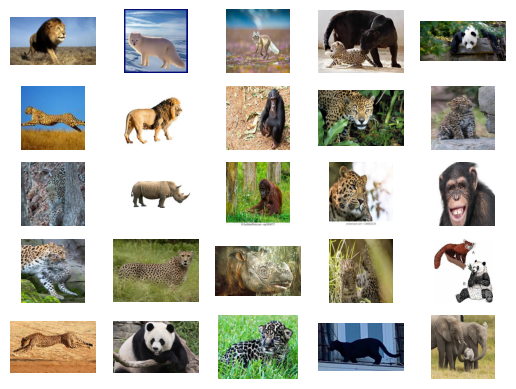

In [15]:
n_rows=5
n_cols=5
f,axarr=plt.subplots(n_rows,n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image=Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis("off")
plt.show()

In [16]:
LR=1e-4
BATCH_SIZE=4
EPOCHS=10

In [17]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [18]:
googlenet_model=models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 149MB/s]


In [19]:
for param in googlenet_model.parameters():
  param.requires_grad=True


In [20]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [21]:
num_classes=len(train['labels'].unique())
num_classes

11

In [22]:
googlenet_model.fc=torch.nn.Linear(googlenet_model.fc.in_features,num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=11, bias=True)

In [23]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [24]:
loss_fun=nn.CrossEntropyLoss()
optimizer=Adam(googlenet_model.parameters(),lr=LR)

total_loss_train_plot=[]
total_acc_train_plot=[]

for epoch in range(EPOCHS):
  total_acc_train=0
  total_loss_train=0
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs=googlenet_model(inputs)
    train_loss=loss_fun(outputs,labels.long())
    total_loss_train+=train_loss.item()
    train_loss.backward()
    train_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
    total_acc_train+=train_acc
    optimizer.step()
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()* 100,4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000,4)}, Train Accuracy {round(total_acc_train/train_dataset.__len__()* 100,4)}')


Epoch 1/10, Train Loss: 1.2238, Train Accuracy 65.3668
Epoch 2/10, Train Loss: 0.6648, Train Accuracy 82.4411
Epoch 3/10, Train Loss: 0.4956, Train Accuracy 87.2439
Epoch 4/10, Train Loss: 0.3639, Train Accuracy 90.2622
Epoch 5/10, Train Loss: 0.2943, Train Accuracy 92.4433
Epoch 6/10, Train Loss: 0.2524, Train Accuracy 93.655
Epoch 7/10, Train Loss: 0.2112, Train Accuracy 94.4481
Epoch 8/10, Train Loss: 0.2248, Train Accuracy 93.8533
Epoch 9/10, Train Loss: 0.1662, Train Accuracy 95.9022
Epoch 10/10, Train Loss: 0.1639, Train Accuracy 95.748


In [25]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0

  for inputs, labels in val_loader:
    predictions=googlenet_model(inputs)
    acc=(torch.argmax(predictions,axis=1)==labels).sum().item()
    total_acc_test+=acc



In [26]:
print(round(total_acc_test/val_dataset.__len__()*100,2))

81.65


Transfer Learning

In [27]:
for param in googlenet_model.parameters():
  param.require_grad=False
googlenet_model.fc=torch.nn.Linear(googlenet_model.fc.in_features,num_classes)
googlenet_model.fc
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [28]:
loss_fun=nn.CrossEntropyLoss()
optimizer=Adam(googlenet_model.parameters(),lr=LR)

total_loss_train_plot=[]
total_acc_train_plot=[]

for epoch in range(EPOCHS):
  total_acc_train=0
  total_loss_train=0
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs=googlenet_model(inputs)
    train_loss=loss_fun(outputs,labels.long())
    total_loss_train+=train_loss.item()
    train_loss.backward()
    train_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
    total_acc_train+=train_acc
    optimizer.step()
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()* 100,4))
  print(f'Epoch{epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000,4)}, Train Accuracy {round(total_acc_train/train_dataset.__len__()* 100,4)}')


Epoch1/10, Train Loss: 0.4506, Train Accuracy 92.1789
Epoch2/10, Train Loss: 0.1896, Train Accuracy 95.3294
Epoch3/10, Train Loss: 0.1596, Train Accuracy 96.0564
Epoch4/10, Train Loss: 0.134, Train Accuracy 96.8495
Epoch5/10, Train Loss: 0.1115, Train Accuracy 97.158
Epoch6/10, Train Loss: 0.1026, Train Accuracy 97.3342
Epoch7/10, Train Loss: 0.0997, Train Accuracy 97.3562
Epoch8/10, Train Loss: 0.0925, Train Accuracy 97.5105
Epoch9/10, Train Loss: 0.0914, Train Accuracy 97.7308
Epoch10/10, Train Loss: 0.0834, Train Accuracy 97.885


In [29]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0

  for inputs, labels in val_loader:
    predictions=googlenet_model(inputs)
    acc=(torch.argmax(predictions,axis=1)==labels).sum().item()
    total_acc_test+=acc


In [30]:
print(round(total_acc_test/val_dataset.__len__()*100,2))

85.5


Convert to ONNX


In [38]:
!pip install onnx onnxscript

In [41]:
import torch.onnx

# After training is complete, convert to ONNX
print("\nConverting model to ONNX...")

# Set model to evaluation mode
googlenet_model.eval()

# Create a dummy input (same size as your training images)
dummy_input = torch.randn(1, 3, 128, 128)  # Adjust if you used different size

# Move to same device as model (CPU or GPU)
device = next(googlenet_model.parameters()).device
dummy_input = dummy_input.to(device)

# Export to ONNX
torch.onnx.export(
    googlenet_model,
    dummy_input,
    "googlenet_animal_classifier.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print("✓ Model successfully converted to ONNX!")

# Download the file (if in Colab)
from google.colab import files
files.download('googlenet_animal_classifier.onnx')
files.download('googlenet_animal_classifier.onnx.data')

/tmp/ipython-input-848265435.py:17: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0104 20:42:19.213000 1802 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features



Converting model to ONNX...
[torch.onnx] Obtain model graph for `GoogLeNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `GoogLeNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 117 of general pattern rewrite rules.
✓ Model successfully converted to ONNX!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import onnx
onnx_model = onnx.load("googlenet_animal_classifier.onnx")
onnx.checker.check_model(onnx_model)
print("✓ ONNX model is valid!")


✓ ONNX model is valid!


In [35]:
torch.onnx.export(
    googlenet_model,
    dummy_input,
    "googlenet_single.onnx",
    export_params=True,
    opset_version=11,  # Use older opset
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output']
)

# Check file size
import os
size_mb = os.path.getsize("googlenet_single.onnx") / (1024 * 1024)
print(f"Model size: {size_mb:.2f} MB")

W0104 20:36:34.454000 1802 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `GoogLeNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `GoogLeNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 114 of general pattern rewrite rules.
Model size: 0.28 MB


Download the pth file as well

In [36]:
import torch

# Save model to .pth
torch.save(googlenet_model.state_dict(), 'googlenet_animal_classifier.pth')
print("✓ Model saved to .pth!")

# Download if in Colab
from google.colab import files
files.download('googlenet_animal_classifier.pth')

✓ Model saved to .pth!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import pickle

# Save the label encoder with the exact mapping used during training
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Also save as JSON for easy viewing
class_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
import json
with open('class_names.json', 'w') as f:
    json.dump(class_mapping, f, indent=2)

print("Label encoder mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

# Download both files
from google.colab import files
files.download('label_encoder.pkl')
files.download('class_names.json')

Label encoder mapping:
  0: African_Elephant
  1: Amur_Leopard
  2: Arctic_Fox
  3: Chimpanzee
  4: Jaguars
  5: Lion
  6: Orangutan
  7: Panda
  8: Panthers
  9: Rhino
  10: cheetahs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>